In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import pywt
import matplotlib.pyplot as plt

from mne import read_epochs, set_log_level, compute_rank, concatenate_epochs

from mne.decoding import CSP
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, LeaveOneOut, StratifiedKFold, cross_val_score, ShuffleSplit
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


from jupyterthemes.stylefx import set_nb_theme
set_nb_theme('gruvboxd')

In [2]:
set_log_level('warning')
epochs = read_epochs('ica_epo.fif').pick('eeg').filter(0,240)
epochs.drop_channels(epochs.info['bads'])
epochs.apply_baseline((-1.4,-0.4))

Number of events,93
Events,left: 18r_pinch: 18r_stop: 18rest: 22right: 17
Time range,-2.000 – 7.999 sec
Baseline,-1.400 – -0.400 sec


[Text(0, -4.9999999999999996e-06, ''),
 Text(0, -4e-06, ''),
 Text(0, -2.9999999999999997e-06, ''),
 Text(0, -1.9999999999999995e-06, ''),
 Text(0, -9.999999999999997e-07, ''),
 Text(0, 0.0, ''),
 Text(0, 1.0000000000000006e-06, ''),
 Text(0, 2.0000000000000003e-06, '')]

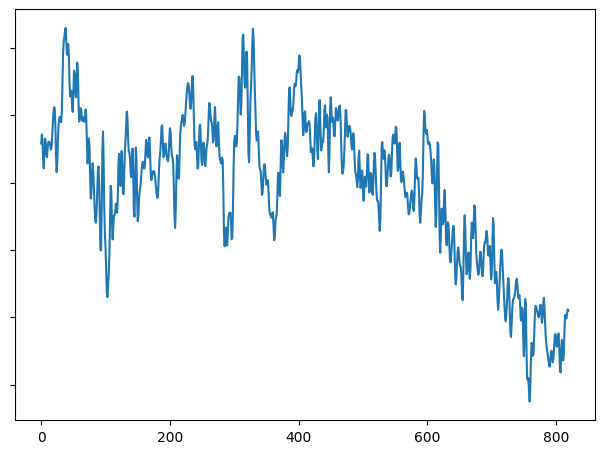

In [3]:
fig, axes = plt.subplots(1)
x = np.array(range(epochs['left'].copy().crop(0.4,1.2).get_data()[5,5].shape[0]))
axes.plot(x,epochs['left'].copy().crop(0.4,1.2).filter(0.,240).average().get_data()[5])
plt.tight_layout()
axes.set_yticklabels([])

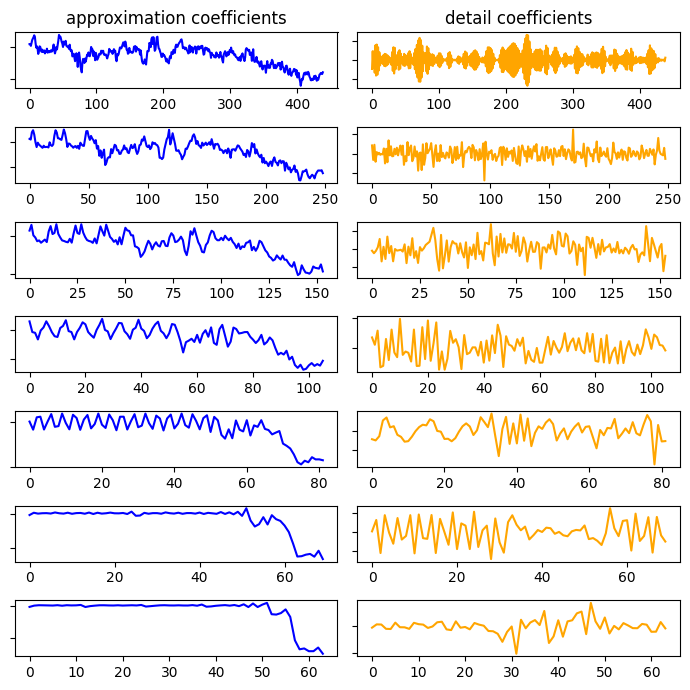

In [4]:
x = epochs['left'].copy().crop(0.4,1.2).filter(0.,240).average().get_data()[5]

fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(7,7))
for lvl in range(7):
#     break;
    (x, coeff_d) = pywt.dwt(x, 'db30')
    axes[lvl, 0].plot(x, color='blue')    
    axes[lvl, 1].plot(coeff_d, color='orange')
    if lvl == 0:
        axes[lvl,0].set_title('approximation coefficients', )
        axes[lvl,1].set_title('detail coefficients', )
    axes[lvl,0].set_yticklabels([])
    axes[lvl,1].set_yticklabels([])
plt.tight_layout()
plt.show()

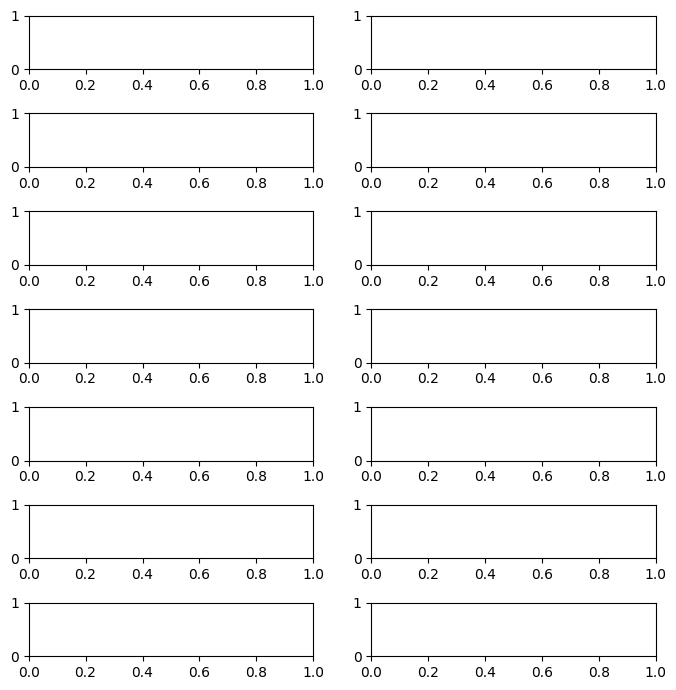

In [5]:
x = epochs['rest'].copy().crop(0.4,1.2).filter(0.,240).average().get_data()[5]

fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(7,7))
for lvl in range(7):
    break;
    (x, coeff_d) = pywt.dwt(x, 'db30')
    axes[lvl, 0].plot(x, color='blue')    
    axes[lvl, 1].plot(coeff_d, color='orange')
    if lvl == 0:
        axes[lvl,0].set_title('approximation coefficients', )
        axes[lvl,1].set_title('detail coefficients', )
    axes[lvl,0].set_yticklabels([])
    axes[lvl,1].set_yticklabels([])
plt.tight_layout()
plt.show()

In [6]:
def dwt_coeff(x, lvl=1, db='db2'):
    coeff = pywt.wavedec(x, db, mode='sym')
    return coeff[lvl]

def dwt_det_coeff(x, db='db2'):
    aprx, det = pywt.dwt(x,db)
    return det

def dwt_aprx_coeff(x, db='db2'):
    aprx, det = pywt.dwt(x,db)
    return aprx

def energy(x):
    return np.sum(x**2)


In [7]:
lda = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')
le = LabelEncoder()

In [8]:
pca = PCA(n_components=0.9)

Left Vs Rest

In [9]:
conditions = ['left','rest']
subset = epochs[conditions].copy()
subset.drop_channels(subset.info['bads'])
subset = subset.pick(['eeg'])
subset = subset.apply_baseline((-1.4,-0.4))
y = le.fit_transform(subset.events[:,2])
train_data = subset.copy().crop(0.4,1.2).get_data()    
time_config = (3,0.4,300,100)

In [12]:
find_best_dwt_score()

wv  db1  at lvl 0  :  0.5719780219780219
.
['F8_max', 'FT7_min', 'T8_min']
.
wv  db1  at lvl 2  :  0.593956043956044
.
['FC6_min', 'TP8_max', 'FC5_min', 'F4_max', 'T7_min']
.
wv  db1  at lvl 3  :  0.7807692307692308
.
['FC6_min', 'TP8_min', 'PO7_max', 'T7_min', 'FT8_min', 'T7_min', 'TP8_min', 'T7_min', 'FC6_min', 'C6_min', 'FC5_max']
.
wv  db3  at lvl 4  :  0.8587912087912087
.
['PO8_min', 'PO8_max', 'PO7_max', 'TP8_min', 'FT7_min', 'F4_max', 'TP8_max', 'FT8_min', 'FT8_min', 'F4_max', 'T7_min', 'CP5_min', 'TP8_min', 'FT8_min', 'AF4_min']
.
wv  db7  at lvl 4  :  0.9027472527472528
.
['PO7_min', 'TP8_max', 'TP8_max', 'TP8_min', 'PO7_max', 'P9_max', 'T7_min', 'F4_min', 'PO8_max', 'T7_max', 'F1_max', 'FC4_min', 'T8_max', 'T8_min', 'CP5_max']
.


In [13]:
#bior
find_best_dwt_score(bior=True)

wv  bior2.2  at lvl 0  :  0.5692307692307692
.
['FT8_max', 'FT7_max', 'TP8_max']
.
wv  bior2.2  at lvl 2  :  0.5714285714285714
.
['FC6_max', 'TP8_max', 'FC3_min', 'FC6_max']
.
wv  bior2.2  at lvl 4  :  0.8324175824175825
.
['C4_min', 'PO8_max', 'TP8_min', 'C4_min', 'PO8_min', 'T7_max', 'T7_min', 'P4_max', 'F7_max', 'FC6_max', 'AF4_max', 'PO7_min', 'TP8_max', 'FT7_max', 'P7_min']
.
wv  bior2.6  at lvl 4  :  0.873076923076923
.
['PO7_min', 'PO8_max', 'TP8_min', 'TP8_max', 'FC6_min', 'TP8_max', 'T8_max', 'TP8_max', 'T7_max', 'F7_max', 'FT7_max', 'F1_min', 'PO7_min', 'PO8_min', 'CP4_max']
.
wv  bior2.8  at lvl 4  :  0.9021978021978022
.
['PO7_min', 'PO8_max', 'TP8_max', 'T8_max', 'FC6_min', 'TP8_max', 'AF8_max', 'T7_max', 'CP5_max', 'T8_min', 'C6_min', 'PO8_min', 'Cz_min', 'FT7_max', 'FT7_max']
.


test with approx coeff

In [14]:
find_best_dwt_score(det=False)

wv  db1  at lvl 0  :  0.5719780219780219
.
['FC5_max', 'T8_min', 'T8_max', 'P3_mean', 'F5_min', 'AF8_min', 'F2_max', 'T7_min', 'F5_min', 'F2_min', 'AF4_max', 'T8_min', 'FC6_min', 'FT8_min', 'Fp1_mean', 'PO3_min']
.
wv  db1  at lvl 2  :  0.582967032967033
.
['FC5_max', 'P3_max', 'T8_max', 'F5_min', 'F2_min', 'AF8_max', 'AF4_max', 'F5_min', 'P3_max', 'FT8_max', 'AF4_max', 'F7_max', 'FT8_max', 'AFz_max', 'AF4_min', 'P3_max']
.
wv  db3  at lvl 0  :  0.5945054945054945
.
['FC5_max', 'T8_min', 'T8_max', 'P3_mean', 'F5_max', 'AF8_min', 'F2_min', 'T7_min', 'F5_min', 'F2_min', 'AF4_max', 'T8_min', 'FC6_min', 'F7_min', 'F1_max', 'PO3_min']
.
wv  db4  at lvl 6  :  0.6010989010989012
.
['FC5_max', 'T8_max', 'P3_max', 'F2_min', 'P10_min', 'F8_max', 'T7_min', 'P3_max', 'P3_max', 'FT7_max', 'AF4_mean', 'FC5_max', 'AF8_min', 'FT8_min', 'PO3_max', 'P3_max']
.


Left Vs Right

In [15]:
conditions = ['left','right']
subset = epochs[conditions].copy()
subset.drop_channels(subset.info['bads'])
subset = subset.pick(['eeg'])
subset = subset.apply_baseline((-1.4,-0.4))
y = le.fit_transform(subset.events[:,2])
train_data = subset.copy().crop(0.2,1).get_data()    
time_config = (3,0.4,300,100)

In [16]:
find_best_dwt_score()

wv  db1  at lvl 0  :  0.6181818181818183
.
['FT8_min', 'AF4_min', 'TP8_max']
.
wv  db1  at lvl 1  :  0.6553030303030304
.
['FC6_min', 'TP8_max', 'AF4_min', 'AF4_min']
.
wv  db3  at lvl 2  :  0.6590909090909091
.
['FC6_min', 'TP8_min', 'T7_min', 'AF4_min']
.
wv  db6  at lvl 2  :  0.6681818181818182
.
['FC6_max', 'TP8_max', 'T7_max', 'T7_max']
.
wv  db9  at lvl 2  :  0.684090909090909
.
['FC6_max', 'TP8_max', 'FC6_max', 'T7_min']
.
wv  db22  at lvl 0  :  0.6886363636363637
.
['FC6_max', 'AF4_max', 'FT8_min']
.
wv  db26  at lvl 2  :  0.703030303030303
.
['FC6_max', 'TP8_max', 'T7_min', 'T7_max']
.


test with approx coeff

In [17]:
find_best_dwt_score(det=False)

wv  db1  at lvl 0  :  0.5803030303030303
.
['FC5_max', 'T8_max', 'P3_min', 'P3_min', 'F7_mean', 'P9_min', 'FT7_min', 'AF4_min', 'F5_min', 'POz_min', 'F8_mean', 'TP8_min', 'FC6_mean', 'AF4_min', 'Pz_max']
.
wv  db1  at lvl 1  :  0.6310606060606061
.
['FC5_max', 'P3_min', 'FT8_min', 'P3_min', 'F7_mean', 'P9_min', 'FT7_min', 'AF4_min', 'F5_min', 'POz_min', 'F8_mean', 'FC6_min', 'AF3_min', 'AF4_min', 'Pz_max']
.
wv  db4  at lvl 1  :  0.6356060606060606
.
['FC5_max', 'F8_max', 'F5_min', 'P3_min', 'F7_mean', 'P9_min', 'FT7_min', 'AF4_min', 'F5_min', 'POz_min', 'F8_mean', 'TP8_min', 'AF3_min', 'AF4_min', 'Pz_max']
.
wv  db10  at lvl 1  :  0.6416666666666667
.
['FC5_max', 'F8_max', 'P3_min', 'P3_min', 'F7_min', 'P9_min', 'FT7_max', 'AF4_min', 'F5_min', 'POz_min', 'F8_mean', 'FC6_max', 'AF3_min', 'AF8_max', 'Pz_mean']
.


In [18]:
#bior
find_best_dwt_score(bior=True)

wv  bior2.2  at lvl 0  :  0.637121212121212
.
['FT8_max', 'AF4_max', 'TP8_max']
.
wv  bior2.4  at lvl 3  :  0.6492424242424242
.
['FC6_max', 'TP8_max', 'T7_max', 'T7_min', 'TP8_max', 'C6_min', 'AF4_max', 'AF4_max']
.
wv  bior2.6  at lvl 0  :  0.6545454545454545
.
['FT8_max', 'AF4_max', 'TP8_max']
.
wv  bior2.6  at lvl 2  :  0.656060606060606
.
['FT8_max', 'TP8_max', 'AF4_max', 'T7_max', 'AF4_max']
.
wv  bior2.8  at lvl 2  :  0.6795454545454545
.
['FC6_max', 'TP8_max', 'T7_max', 'T7_min']
.
wv  bior3.3  at lvl 2  :  0.681060606060606
.
['FC6_max', 'TP8_min', 'FC6_max', 'AF4_max']
.


CSP to one level

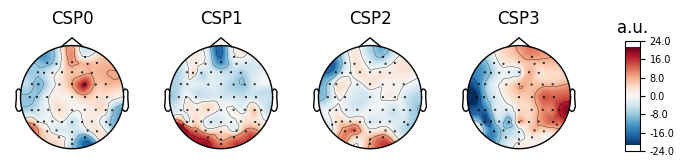

In [9]:
data = subset.copy().crop(.1,1.2).get_data()
data = np.apply_along_axis(dwt_coeff, 2, data, db='db2',lvl=1)
csp.fit(data, y)
csp.plot_patterns(subset.info)
print()

Stat features of DWT coefficients 

In [10]:
initial_features = []
st_features = ['mean','energy','std','max','min']
for ft in st_features:
    for ch in subset.info['chs']:
        initial_features.append(ch['ch_name'] + '_' + ft)

In [11]:
def find_best_dwt_score(det=True, bior=False):
    scores = []
    best_score = 0
    dbs = ['db1','db2','db3','db4','db5','db6','db7','db8','db9', 'db10',
           'db11','db13','db14','db16','db17','db18','db20','db22','db24','db26','db30','db31','db32']
    if bior:
        dbs = ['bior2.2',
             'bior2.4',
             'bior2.6',
             'bior2.8',
             'bior3.1',
             'bior3.3',
             'bior3.5',
             'bior3.7',
             'bior3.9',
             'bior4.4',
             'bior5.5',]

    for db in dbs :
        x_aprox_coeff = train_data
    
        for lvl in range(8):
            x_det_coeff = np.apply_along_axis(dwt_det_coeff, 2, x_aprox_coeff, db=db)
            x_aprox_coeff = np.apply_along_axis(dwt_aprx_coeff, 2, x_aprox_coeff, db=db)

            rep_score = []
            for train_rep in range(10):
                median_score=[]
                cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=25 + train_rep)

                cv_split = cv.split(train_data, y)
                for train_idx, test_idx in cv_split:
                    y_train, y_test = y[train_idx], y[test_idx]
                    X = []
                    X_tst = []
                    if det:
                        x_tr = x_det_coeff[train_idx]
                    else :
                        x_tr = x_aprox_coeff[train_idx]

                    X.append(np.apply_along_axis(np.mean, 2, x_tr))
                    X.append(np.apply_along_axis(energy, 2, x_tr))
                    X.append(np.apply_along_axis(np.std, 2, x_tr))
                    X.append(np.apply_along_axis(np.max, 2, x_tr))
                    X.append(np.apply_along_axis(np.min, 2, x_tr))

                    X_tst = []
                    if det:
                        x_tst = x_det_coeff[test_idx]
                    else :
                        x_tst = x_aprox_coeff[test_idx]
                    X_tst.append(np.apply_along_axis(np.mean, 2, x_tst))
                    X_tst.append(np.apply_along_axis(energy, 2, x_tst))
                    X_tst.append(np.apply_along_axis(np.std, 2, x_tst))
                    X_tst.append(np.apply_along_axis(np.max, 2, x_tst))
                    X_tst.append(np.apply_along_axis(np.min, 2, x_tst))

                    X = np.concatenate(X, axis=1)                
                    X_tst = np.concatenate(X_tst, axis=1)
                    X = pca.fit_transform(X)
                    X_tst = pca.transform(X_tst)

                    lda.fit(X, y_train)
                    median_score.append(np.median(lda.score(X_tst, y_test)))

                rep_score.append(np.median(median_score))

            lvl_mean = np.mean(rep_score)
            if lvl_mean > best_score : 
                best_score = lvl_mean
                n_pcs = pca.components_.shape[0]
                pca_features = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]
                most_important = [initial_features[pca_features[i]] for i in range(n_pcs)]
                print('wv ',db,' at lvl', lvl, ' : ', best_score)
                print('.')
#                 print(rep_score)
                print(most_important)
                print('.')


In [13]:
def test_dwt_conf():
    scores = []
    dbs = ['db1', 'db2', 'db3', 'db4', 'db5', 'db6', 'db7', 'db8']

    for db in dbs:
        db_score = []  
        max_lvl_score = 0
        for lvl in np.array(range(5))+1 :
            median_score = []
            for train_rep in range(10):
                cv = ShuffleSplit(n_splits=3, test_size=0.25, random_state=25 + train_rep)
                cv_split = cv.split(train_data)

                for train_idx, test_idx in cv_split:
                    y_train, y_test = y[train_idx], y[test_idx]
                    X = []
                    x_tr = np.apply_along_axis(dwt_coeff, 2, train_data[train_idx], lvl = lvl, db=db)
                    X.append(np.apply_along_axis(np.mean, 2, x_tr))
                    X.append(np.apply_along_axis(energy, 2, x_tr))
                    X.append(np.apply_along_axis(np.std, 2, x_tr))
                    X.append(np.apply_along_axis(np.max, 2, x_tr))
                    X.append(np.apply_along_axis(np.min, 2, x_tr))

                    X_tst = []
                    x_tst = np.apply_along_axis(dwt_coeff, 2, train_data[test_idx], lvl = lvl, db=db)
                    X_tst.append(np.apply_along_axis(np.mean, 2, x_tst))
                    X_tst.append(np.apply_along_axis(energy, 2, x_tst))
                    X_tst.append(np.apply_along_axis(np.std, 2, x_tst))
                    X_tst.append(np.apply_along_axis(np.max, 2, x_tst))
                    X_tst.append(np.apply_along_axis(np.min, 2, x_tst))

                    X = np.concatenate(X, axis=1)
                    X_tst = np.concatenate(X_tst, axis=1)

                    X = pca.fit_transform(X)
                    X_tst = pca.transform(X_tst)

                    lda.fit(X, y_train)
                    median_score.append(np.median(lda.score(X_tst, y_test)))

            current_score = np.mean(median_score)
            if current_score > max_lvl_score:
                print('best score ', db, ' at ', lvl, ': ', current_score)
                max_lvl_score = current_score

            db_score.append(max_lvl_score)

test DWT overlapping windows

In [14]:
def test_dwt_more_windows(lvl, db, config):
    median_score = []
    n_windows, tmin, width, overlap = config
    train_data = subset.copy().crop(tmin,1.9).get_data()

    for train_rep in range(10):
        cv = ShuffleSplit(n_splits=3, test_size=0.25, random_state=25 + train_rep)
        cv_split = cv.split(train_data)

        for train_idx, test_idx in cv_split:
            y_train, y_test = y[train_idx], y[test_idx]
            X = []
            X_tst = []
            
            w_min = 0
            for i in range(n_windows):
                w_max = w_min + width
                x_tr = np.apply_along_axis(dwt_coeff, 2, train_data[train_idx,:,w_min:w_max], lvl = lvl, db=db)
                
                X.append(np.apply_along_axis(np.mean, 2, x_tr))
                X.append(np.apply_along_axis(energy, 2, x_tr))
                X.append(np.apply_along_axis(np.std, 2, x_tr))
                X.append(np.apply_along_axis(np.max, 2, x_tr))
                X.append(np.apply_along_axis(np.min, 2, x_tr))

                x_tst = np.apply_along_axis(dwt_coeff, 2, train_data[test_idx,:,w_min:w_max], lvl = lvl, db=db)
                X_tst.append(np.apply_along_axis(np.mean, 2, x_tst))
                X_tst.append(np.apply_along_axis(energy, 2, x_tst))
                X_tst.append(np.apply_along_axis(np.std, 2, x_tst))
                X_tst.append(np.apply_along_axis(np.max, 2, x_tst))
                X_tst.append(np.apply_along_axis(np.min, 2, x_tst))
                w_min += w_max - overlap


            X = np.concatenate(X, axis=1)
            X_tst = np.concatenate(X_tst, axis=1)

            X = pca.fit_transform(X)
            X_tst = pca.transform(X_tst)

            lda.fit(X, y_train)
            median_score.append(np.median(lda.score(X_tst, y_test)))
    
    print(np.mean(median_score))

CSP avg power and other statistical features

In [15]:
def test_csp_dwt(lvl, db):
    median_score = []
    for train_rep in range(10):
        cv = ShuffleSplit(n_splits=3, test_size=0.25, random_state=25 + train_rep)
        cv_split = cv.split(train_data)

        for train_idx, test_idx in cv_split:
            y_train, y_test = y[train_idx], y[test_idx]

            x_tr = np.apply_along_axis(dwt_coeff, 2, train_data[train_idx], lvl = lvl, db = db)
            pca = PCA(n_components= x_tr.shape[1])
#             pca.fit_transform(x_tr)
            csp.fit(x_tr, y_train)
            x_tr = csp.transform(x_tr)
            x_tr = np.apply_along_axis(avg_pwr, 2, x_tr)
            x_tr = np.apply_along_axis(standarize, 1, x_tr, mean=csp.mean_, std=csp.std_)

            x_tst = np.apply_along_axis(dwt_coeff, 2, train_data[test_idx], lvl = lvl, db = db)
            x_tst = csp.transform(x_tst)
            x_tst = np.apply_along_axis(avg_pwr, 2, x_tst)
            X_tst = np.apply_along_axis(standarize, 1, x_tst, mean=csp.mean_, std=csp.std_)
            
            lda.fit(x_tr, y_train)
            median_score.append(np.median(lda.score(X_tst, y_test)))

    print(np.mean(median_score))